In [1]:

import numpy as np
import matplotlib.pyplot as plt
import blip_analysis as ba
import exp_blip_models as ebm
import numpy as np
from scipy.stats import ttest_ind
import pickle
from matplotlib.gridspec import GridSpec
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from scipy.stats import poisson
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from label_axes import label_axes
import json
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

b


In [2]:
def plot_difference_distributions(ax, conc_models, onset_models, color=['r', 'b']):
    ''' Plot the difference in test scores between the two models for each cell.
    not being used now but needed for the sorted arg in the next function'''
    conc_test_scores = np.array([i.test_scores.mean(axis=-1) for i in conc_models])
    onset_test_scores = np.array([i.test_scores.mean(axis=-1) for i in onset_models])
    diffs = np.array(conc_test_scores - onset_test_scores)
    sorted_arg = np.argsort(diffs.mean(axis=-1))
    ax.errorbar(range(130), diffs.mean(axis=-1)[sorted_arg], yerr=diffs.std(axis=-1)[sorted_arg], fmt='.', color='k',  markersize=0, elinewidth=0.5)
    conc_best, onset_best, colors = find_best_fits(conc_models, onset_models, colors_base=color+['gray'])
    ax.scatter(range(130), diffs.mean(axis=-1)[sorted_arg], c=np.array(colors)[sorted_arg], s=3, zorder=10)
    print(len(conc_best), len(onset_best))
    return sorted_arg

def find_best_fits(conc_models, onset_models, colors_base=['r', 'b', 'gray']):
    ''' Find the cells that are significantly better fit by the conc model or the onset model.'''
    ttests = []
    ttests_conc = []
    ttests_onset = []
    colors = []
    conc_scores = np.array([i.test_scores.mean(axis=-1) for i in conc_models])
    onset_scores = np.array([i.test_scores.mean(axis=-1) for i in onset_models])
    
    for i in range(130):
        ttest = ttest_ind(conc_scores[i], onset_scores[i], equal_var=False)[1]*130
        ttests.append(ttest)
        if ttest < 0.05 and np.mean(conc_scores[i]) < np.mean(onset_scores[i]):
            ttests_conc.append(i)
            colors.append(colors_base[0])
        elif ttest < 0.05 and np.mean(conc_scores[i]) > np.mean(onset_scores[i]):
            ttests_onset.append(i)
            colors.append(colors_base[1])
        else:
            colors.append(colors_base[2])
    return ttests_conc, ttests_onset, colors

def plot_split_models_response(ax1, ax2, model1, model2, isi=1, colors=None, fontsize=8, legend=True, labels=None):
    ''' Plot the response of two models to the same cell used in part B and C of the figure.'''
    if colors is None:
        colors = ['k', 'C0', 'C1']
    ax1.errorbar(np.arange(0, 32*isi, isi), model1.X_test_avg.mean(axis=0), yerr=(model1.X_test_avg.mean(axis=0) - model1.X_test_avg.min(axis=0), model1.X_test_avg.max(axis=0) - model1.X_test_avg.mean(axis=0)),fmt='.', color=colors[0],  markersize=0, elinewidth=0.5)
    ax1.scatter(np.arange(0, 32*isi, isi), model1.X_test_avg.mean(axis=0), color=colors[0], s=3, zorder=10)
    ax1.errorbar(np.arange(0, 32*isi, isi), model1.pred_test_avg.mean(axis=0), yerr=(model1.pred_test_avg.mean(axis=0) - model1.pred_test_avg.min(axis=0), model1.pred_test_avg.max(axis=0) - model1.pred_test_avg.mean(axis=0)), fmt='.', color=colors[1],  markersize=0, elinewidth=0.5)
    ax1.scatter(np.arange(0, 32*isi, isi), model1.pred_test_avg.mean(axis=0), color=colors[1], s=3, zorder=10)

    ax2.errorbar(np.arange(0, 32*isi, isi), model2.X_test_avg.mean(axis=0), yerr=(model2.X_test_avg.mean(axis=0) - model2.X_test_avg.min(axis=0), model2.X_test_avg.max(axis=0) - model2.X_test_avg.mean(axis=0)),fmt='.', color=colors[0],  markersize=0, elinewidth=0.5)
    ax2.scatter(np.arange(0, 32*isi, isi), model2.X_test_avg.mean(axis=0), color=colors[0], s=3, zorder=10)
    ax2.errorbar(np.arange(0, 32*isi, isi), model2.pred_test_avg.mean(axis=0), yerr=(model2.pred_test_avg.mean(axis=0) - model2.pred_test_avg.min(axis=0), model2.pred_test_avg.max(axis=0) - model2.pred_test_avg.mean(axis=0)), fmt='.', color=colors[2],  markersize=0, elinewidth=0.5)
    ax2.scatter(np.arange(0, 32*isi, isi), model2.pred_test_avg.mean(axis=0), color=colors[2], s=3, zorder=10)

    x_ticks = np.arange(0, 32*isi, isi)
    ax1.set_xticks(x_ticks);
    ax1.set_xticklabels(glyphs, rotation=90, fontsize=fontsize);
    ax2.set_xticks(x_ticks);
    ax2.set_xticklabels(glyphs, rotation=90, fontsize=fontsize);
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_yticklabels([])
    [ax2.scatter([], [], color=colors[i], s=3, label=labels[i]) for i in range(len(colors))]
    
    if legend:
        ax2.legend()


def plot_best_cm(ax, cms, true_cm, fontsize=8, show_xticks=True, show_yticks=True, colorbar=True):
    ''' Plot the confusion matrix with the highest correlation to the true matrix'''
    best_idx = np.argmax([np.corrcoef(i.flatten(), true_cm.flatten())[0, 1] for i in cms])
    print(best_idx)
    
    im = ax.imshow(cms[best_idx], cmap='plasma', vmin=0)
    
    ax.set_xticks(range(32))
    ax.set_yticks(range(32))
    if show_xticks:
        ax.set_xticklabels(glyphs, rotation=90, fontsize=fontsize)
    else:
        ax.set_xticklabels([])
    if show_yticks:
        ax.set_yticklabels(glyphs, fontsize=fontsize)
    else:
        ax.set_yticklabels([])
    ax.set_ylim(31.5, -0.5)
    if colorbar:
        cbar = plt.colorbar(mappable=im, ax=ax)
        return im, np.max(cms[best_idx]), cbar
    else:
        return im, np.max(cms[best_idx])

def plot_correlations(true_corrs, diff_corrs, conc_corrs, onset_corrs, joined_corrs, identiy, colors, ax=None):
    ''' Plot the correlations between the true and predicted confusion matrices for the different models'''

    if ax is None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)
    markers = style_params['odour_markers']
    odour_labels = style_params['odour_labels']
    facecolors = [mpl.colors.to_rgba(i, alpha=0.5) for i in colors]
    scatter = ax.scatter(range(6), [true_corrs[0], diff_corrs[0], conc_corrs[0], onset_corrs[0], joined_corrs[0], identiy[0]], marker=markers[0], label=odour_labels[0], facecolors=facecolors, edgecolors=colors)
    ax.scatter(range(6), [true_corrs[1], diff_corrs[1], conc_corrs[1], onset_corrs[1], joined_corrs[1], identiy[1]], marker=markers[1], label=odour_labels[1], facecolors=facecolors, edgecolors=colors)
    ax.scatter(range(6), [true_corrs[2], diff_corrs[2], conc_corrs[2], onset_corrs[2], joined_corrs[2], identiy[2]], marker=markers[2], label=odour_labels[2], facecolors=facecolors, edgecolors=colors)

    # ax.plot([0, 0], [np.min(true_corrs), np.max(true_corrs)], color='k', linestyle='--', zorder=-10)
    # ax.plot([1, 1], [np.min(diff_corrs), np.max(diff_corrs)], color='k', linestyle='--', zorder=-10)
    # ax.plot([2, 2], [np.min(conc_corrs), np.max(conc_corrs)], color='k', linestyle='--', zorder=-10)
    # ax.plot([3, 3], [np.min(onset_corrs), np.max(onset_corrs)], color='k', linestyle='--', zorder=-10)
    # ax.plot([4, 4], [np.min(joined_corrs), np.max(joined_corrs)], color='k', linestyle='--', zorder=-10)
    # ax.plot([5, 5], [np.min(identiy), np.max(identiy)], color='k', linestyle='--', zorder=-10)

    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(range(6))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_ylabel('Correlation coefficient')

In [3]:
glyphs = ba.get_glyphs()
style_params = json.load(open('../Data/style_params.json', 'r'))
conc_models1 = pickle.Unpickler(open('../Data/230320_conc_models1.pkl', 'rb')).load()
conc_models2 = pickle.Unpickler(open('../Data/230320_conc_models2.pkl', 'rb')).load()
conc_models3 = pickle.Unpickler(open('../Data/230320_conc_models3.pkl', 'rb')).load()
onset_models1 = pickle.Unpickler(open('../Data/230320_onset_models1.pkl', 'rb')).load()
onset_models2 = pickle.Unpickler(open('../Data/230320_onset_models2.pkl', 'rb')).load()
onset_models3 = pickle.Unpickler(open('../Data/230320_onset_models3.pkl', 'rb')).load()
cao_models1 = pickle.Unpickler(open('../Data/230320_cao_models1.pkl', 'rb')).load()
cao_models2 = pickle.Unpickler(open('../Data/230320_cao_models2.pkl', 'rb')).load()
cao_models3 = pickle.Unpickler(open('../Data/230320_cao_models3.pkl', 'rb')).load()
diff_models1 = pickle.Unpickler(open('../Data/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Data/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Data/230320_diff_models3.pkl', 'rb')).load()
base_models1 = pickle.Unpickler(open('../Data/230320_base_models1.pkl', 'rb')).load()
base_models2 = pickle.Unpickler(open('../Data/230320_base_models2.pkl', 'rb')).load()
base_models3 = pickle.Unpickler(open('../Data/230320_base_models3.pkl', 'rb')).load()

In [4]:
conc_test_scores1 = np.array([i.test_scores.mean(axis=-1) for i in conc_models1])
conc_test_scores2 = np.array([i.test_scores.mean(axis=-1) for i in conc_models2])
conc_test_scores3 = np.array([i.test_scores.mean(axis=-1) for i in conc_models3])
onset_test_scores1 = np.array([i.test_scores.mean(axis=-1) for i in onset_models1])
onset_test_scores2 = np.array([i.test_scores.mean(axis=-1) for i in onset_models2])
onset_test_scores3 = np.array([i.test_scores.mean(axis=-1) for i in onset_models3])

mean_conc_test_scores1 = conc_test_scores1.mean(axis=-1)
mean_conc_test_scores2 = conc_test_scores2.mean(axis=-1)
mean_conc_test_scores3 = conc_test_scores3.mean(axis=-1)
mean_onset_test_scores1 = onset_test_scores1.mean(axis=-1)
mean_onset_test_scores2 = onset_test_scores2.mean(axis=-1)
mean_onset_test_scores3 = onset_test_scores3.mean(axis=-1)


In [5]:
avg_diff1 = (conc_test_scores1 - onset_test_scores1).mean(axis=-1)
avg_diff2 = (conc_test_scores2 - onset_test_scores2).mean(axis=-1)
avg_diff3 = (conc_test_scores3 - onset_test_scores3).mean(axis=-1)

std_diffs1 = (conc_test_scores1 - onset_test_scores1).std(axis=-1)
std_diffs2 = (conc_test_scores2 - onset_test_scores2).std(axis=-1)
std_diffs3 = (conc_test_scores3 - onset_test_scores3).std(axis=-1)

In [6]:
data_joined = np.load('../Data/230612_data_joined.npy')
#cms = [confusion_matrix(data[i, :, 1].reshape(-1), data[i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms1 = [confusion_matrix(data_joined[0, i, :, 1].reshape(-1), data_joined[0, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms2 = [confusion_matrix(data_joined[1, i, :, 1].reshape(-1), data_joined[1, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms3 = [confusion_matrix(data_joined[2, i, :, 1].reshape(-1), data_joined[2, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_conc1 = [confusion_matrix(data_joined[4, i, :, 1].reshape(-1), data_joined[4, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_onset1 = [confusion_matrix(data_joined[3, i, :, 1].reshape(-1), data_joined[3, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_joined1 = [confusion_matrix(data_joined[5, i, :, 1].reshape(-1), data_joined[5, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_conc2 = [confusion_matrix(data_joined[6, i, :, 1].reshape(-1), data_joined[6, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_onset2 = [confusion_matrix(data_joined[7, i, :, 1].reshape(-1), data_joined[7, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_joined2 = [confusion_matrix(data_joined[8, i, :, 1].reshape(-1), data_joined[8, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_conc3 = [confusion_matrix(data_joined[9, i, :, 1].reshape(-1), data_joined[9, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_onset3 = [confusion_matrix(data_joined[10, i, :, 1].reshape(-1), data_joined[10, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]
cms_joined3 = [confusion_matrix(data_joined[11, i, :, 1].reshape(-1), data_joined[11, i, :, 0].reshape(-1), labels=range(32), normalize='true') for i in range(20)]

In [7]:
true_classifiers = pickle.Unpickler(open('../Fig3/../Fig3/230315_full_classifier_RFs.pkl', 'rb')).load()
preds = true_classifiers[:, :, 1]
preds = np.array([np.hstack(i) for i in preds])
trues = [i for j in range(100) for i in range(32)]
cm_true1 = confusion_matrix(trues, preds[0], labels=range(32), normalize='true')
cm_true2 = confusion_matrix(trues, preds[1], labels=range(32), normalize='true')
cm_true3 = confusion_matrix(trues, preds[2], labels=range(32), normalize='true')


In [8]:
max_corrs = lambda cms, cm_true: np.max([np.corrcoef(i.flatten(), cm_true.flatten())[0, 1] for i in cms])
diff_corrs = [max_corrs(cms1, cm_true1), max_corrs(cms2, cm_true2), max_corrs(cms3, cm_true3)]
conc_corrs = [max_corrs(cms_conc1, cm_true1), max_corrs(cms_conc2, cm_true2), max_corrs(cms_conc3, cm_true3)]
onset_corrs = [max_corrs(cms_onset1, cm_true1), max_corrs(cms_onset2, cm_true2), max_corrs(cms_onset3, cm_true3)]
joined_corrs = [max_corrs(cms_joined1, cm_true1), max_corrs(cms_joined2, cm_true2), max_corrs(cms_joined3, cm_true3)]
true_corrs = np.triu(np.corrcoef([cm_true1.flatten(), cm_true2.flatten(), cm_true3.flatten()]), 1).flatten()
true_corrs = true_corrs[np.where(true_corrs != 0)]
identiy = [np.corrcoef([i.flatten(), np.identity(32).flatten()])[0, 1] for i in [cm_true1, cm_true2, cm_true3]]
print(identiy)

[0.489757277225493, 0.41008889630176826, 0.4357846050789411]


20 61
26 36


11
15
12
17
(0.0, None)


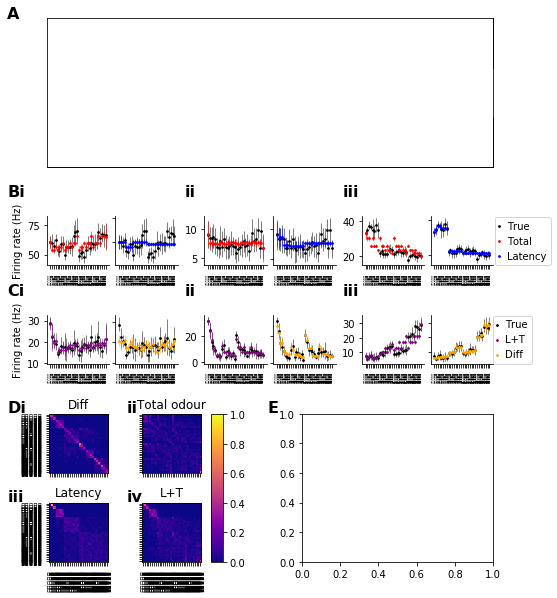

In [11]:
fig = plt.figure(figsize=(8, 10))
gs = GridSpec(6, 3, hspace=1, wspace=0.2, )
diff_ax1 = fig.add_subplot(gs[0, :])
diff_ax2 = fig.add_subplot(gs[1, :])
conc_vs_onset_args = plot_difference_distributions(diff_ax1, conc_models1, onset_models1)
cao_vs_diff_args = plot_difference_distributions(diff_ax2, cao_models1, diff_models1, color=['purple', 'orange'])
diff_ax1.set_xticks([])
diff_ax2.set_xticks([])
diff_ax1.set_yticks([])
diff_ax2.set_yticks([])

schem_ax = fig.add_subplot(gs[:2, :])
schem_ax.set_xticks([])
schem_ax.set_yticks([])


low_conc_model = conc_models1[conc_vs_onset_args[0]]
low_onset_model = onset_models1[conc_vs_onset_args[0]]
high_conc_model = conc_models1[conc_vs_onset_args[-1]]
high_onset_model = onset_models1[conc_vs_onset_args[-1]]
mid_conc_model = conc_models1[conc_vs_onset_args[65]]
mid_onset_model = onset_models1[conc_vs_onset_args[65]]
subgs1 = gs[2, 0].subgridspec(1, 2, wspace=0.1)
subgs2 = gs[2, 1].subgridspec(1, 2, wspace=0.1)
subgs3 = gs[2, 2].subgridspec(1, 2, wspace=0.1)

#sub_gs = gs[2:4, :].subgridspec(2, 6, wspace=0.5)

low_model_ax_cao1 = fig.add_subplot(subgs1[0])
low_model_ax_cao2 = fig.add_subplot(subgs1[1])
mid_model_ax_cao1 = fig.add_subplot(subgs2[0])
mid_model_ax_cao2 = fig.add_subplot(subgs2[1])
high_model_ax_cao1 = fig.add_subplot(subgs3[0])
high_model_ax_cao2 = fig.add_subplot(subgs3[1])

plot_split_models_response(low_model_ax_cao1, low_model_ax_cao2, low_conc_model, low_onset_model, isi=2, labels=['True','Total', 'Latency'], colors=['k', 'r', 'b'], legend=False)
plot_split_models_response(mid_model_ax_cao1, mid_model_ax_cao2, mid_conc_model, mid_onset_model, isi=2, colors=['k', 'r', 'b'], labels = ['True','Total', 'Latency'], legend=False)
plot_split_models_response(high_model_ax_cao1, high_model_ax_cao2, high_conc_model, high_onset_model, isi=2, labels=['True','Total', 'Latency'], colors=['k', 'r', 'b'], legend=False)
#plot_models_response(low_model_ax_cao, [low_conc_model, low_onset_model], isi=2, labels=['True', 'Conc', 'Onset'], colors=['k','r', 'b'], legend=False)
#plot_models_response(high_model_ax_cao, [high_conc_model, high_onset_model], isi=2, colors=['k','r', 'b'], labels=['True', 'Conc', 'Onset'])
#plot_models_response(mid_model_ax_cao, [mid_conc_model, mid_onset_model], isi=2, colors=['k','r', 'b'])
high_model_ax_cao2.legend(ncol=1, handlelength=0.0, bbox_to_anchor=(2, 0.5), loc='right')
low_model_ax_cao1.set_ylabel('Firing rate (Hz)')

[i.set_xticklabels(glyphs, fontsize=4) for i in [low_model_ax_cao1, low_model_ax_cao2, mid_model_ax_cao1, mid_model_ax_cao2, high_model_ax_cao1, high_model_ax_cao2]]

low_diff_model = diff_models1[cao_vs_diff_args[0]]
low_cao_model = cao_models1[cao_vs_diff_args[0]]
high_diff_model = diff_models1[cao_vs_diff_args[-1]]
high_cao_model = cao_models1[cao_vs_diff_args[-1]]
mid_diff_model = diff_models1[cao_vs_diff_args[65]]
mid_cao_model = cao_models1[cao_vs_diff_args[65]]

subgs1 = gs[3, 0].subgridspec(1, 2, wspace=0.1)
subgs2 = gs[3, 1].subgridspec(1, 2, wspace=0.1)
subgs3 = gs[3, 2].subgridspec(1, 2, wspace=0.1)


low_model_ax1 = fig.add_subplot(subgs1[0])
low_model_ax2 = fig.add_subplot(subgs1[1])
mid_model_ax1 = fig.add_subplot(subgs2[0])
mid_model_ax2 = fig.add_subplot(subgs2[1])
high_model_ax1 = fig.add_subplot(subgs3[0])
high_model_ax2 = fig.add_subplot(subgs3[1])
# low_model_ax = fig.add_subplot(gs[3, 0])
# mid_model_ax = fig.add_subplot(gs[3, 1])
# high_model_ax = fig.add_subplot(gs[3, 2])

# plot_models_response(low_model_ax, [low_cao_model, low_diff_model], isi=2, labels=['True', 'CAO', 'Diff'], colors=['k', 'purple','orange'], legend=False)
# plot_models_response(high_model_ax, [high_cao_model, high_diff_model], isi=2, colors=['k','purple','orange'], labels=['True', 'CAO', 'Diff'],)
# plot_models_response(mid_model_ax, [mid_cao_model, mid_diff_model], isi=2, colors=['k','purple','orange'])

plot_split_models_response(low_model_ax1, low_model_ax2, low_cao_model, low_diff_model, isi=2, labels=['True','L+T', 'Diff'], colors=['k', 'purple', 'orange'], legend=False)
plot_split_models_response(mid_model_ax1, mid_model_ax2, mid_cao_model, mid_diff_model, isi=2, colors=['k', 'purple', 'orange'], labels = ['True','L+T', 'Diff'], legend=False)
plot_split_models_response(high_model_ax1, high_model_ax2, high_cao_model, high_diff_model, isi=2, labels=['True','L+T', 'Diff'], colors=['k', 'purple', 'orange'], legend=False)

high_model_ax2.legend(ncol=1, handlelength=0.0, bbox_to_anchor=(1.7, 0.5), loc='right')
low_model_ax1.set_ylabel('Firing rate (Hz)')
[i.set_xticklabels(glyphs, fontsize=4) for i in [low_model_ax1, low_model_ax2, mid_model_ax1, mid_model_ax2, high_model_ax1, high_model_ax2]]


sub_gs = gs[-2:, :].subgridspec(2, 4, wspace=1, hspace=0.5)
cm_ax1 = fig.add_subplot(sub_gs[0, 0])
cm_ax2 = fig.add_subplot(sub_gs[0, 1])
cm_ax3 = fig.add_subplot(sub_gs[1, 0])
cm_ax4 = fig.add_subplot(sub_gs[1, 1])
corr_ax = fig.add_subplot(sub_gs[:, 2:])

im1, vmax1 = plot_best_cm(cm_ax1, cms1, cm_true1, show_xticks=False, colorbar=False)
im2, vmax2 = plot_best_cm(cm_ax2, cms_conc1, cm_true1, show_yticks=False, show_xticks=False, colorbar=False)
im3, vmax3 = plot_best_cm(cm_ax3, cms_onset1, cm_true1, show_yticks=True, colorbar=False)
im4, vmax4 = plot_best_cm(cm_ax4, cms_joined1, cm_true1, show_yticks=False, colorbar=False)
#plot_correlations(true_corrs, diff_corrs, conc_corrs, onset_corrs, joined_corrs, identiy, colors[:-1], ax=corr_ax)
print(im1.get_clim())
vmax = np.max([vmax1, vmax2, vmax3, vmax4])
[i.set_clim([0, vmax]) for i in [im1, im2, im3, im4]]
plt.draw()

# cm_ax1_pos = cm_ax1.get_position()
# cm_ax1.set_position([cm_ax1_pos.x0 + 0.05, cm_ax1_pos.y0, cm_ax1_pos.width, cm_ax1_pos.height])
# cm_ax3_pos = cm_ax3.get_position()
# cm_ax3.set_position([cm_ax3_pos.x0 + 0.05, cm_ax3_pos.y0, cm_ax3_pos.width, cm_ax3_pos.height])
cm_ax2_pos = cm_ax2.get_position()
cm_ax2.set_position([cm_ax2_pos.x0- 0.06, cm_ax2_pos.y0, cm_ax2_pos.width, cm_ax2_pos.height])
cm_ax4_pos = cm_ax4.get_position()
cm_ax4.set_position([cm_ax4_pos.x0- 0.06, cm_ax4_pos.y0, cm_ax4_pos.width, cm_ax4_pos.height])
cbar_ax = fig.add_axes([cm_ax2_pos.x0 + 0.06, cm_ax4_pos.y0, 0.02, 0.205])
plt.colorbar(im3, cax=cbar_ax)
cm_ax1.set_title('Diff')
cm_ax2.set_title('Total odour')
cm_ax3.set_title('Latency')
cm_ax4.set_title('L+T')
axes = [schem_ax, low_model_ax_cao1, mid_model_ax_cao1, high_model_ax_cao1, low_model_ax1, mid_model_ax1, high_model_ax1, cm_ax1, cm_ax2, cm_ax3, cm_ax4, corr_ax]
labels = ['A', 'Bi', 'ii', 'iii', 'Ci', 'ii', 'iii', 'Di', 'ii', 'iii', 'iv', 'E']
label_axes.label_axes(axes, labels, align_x=[[0, 1, 4, 7], [2, 5], [3, 6], [7, 9], [8, 10]], align_y= [[1, 2, 3], [4, 5, 6], [7, 8, 11], [9, 10]], fontweight='bold', fontsize=16, align_x_fun=np.min, align_y_fun=np.max, dx=[-0.01, -0.01, 0, 0, -0.01, 0, 0, -0.01, -0.015, -0.015, -0.02, -0.02], dy=[0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.02, -0.02, -0.02, -0.02, -0.02])
#plt.savefig('230703_fig4.pdf', bbox_inches='tight')

11


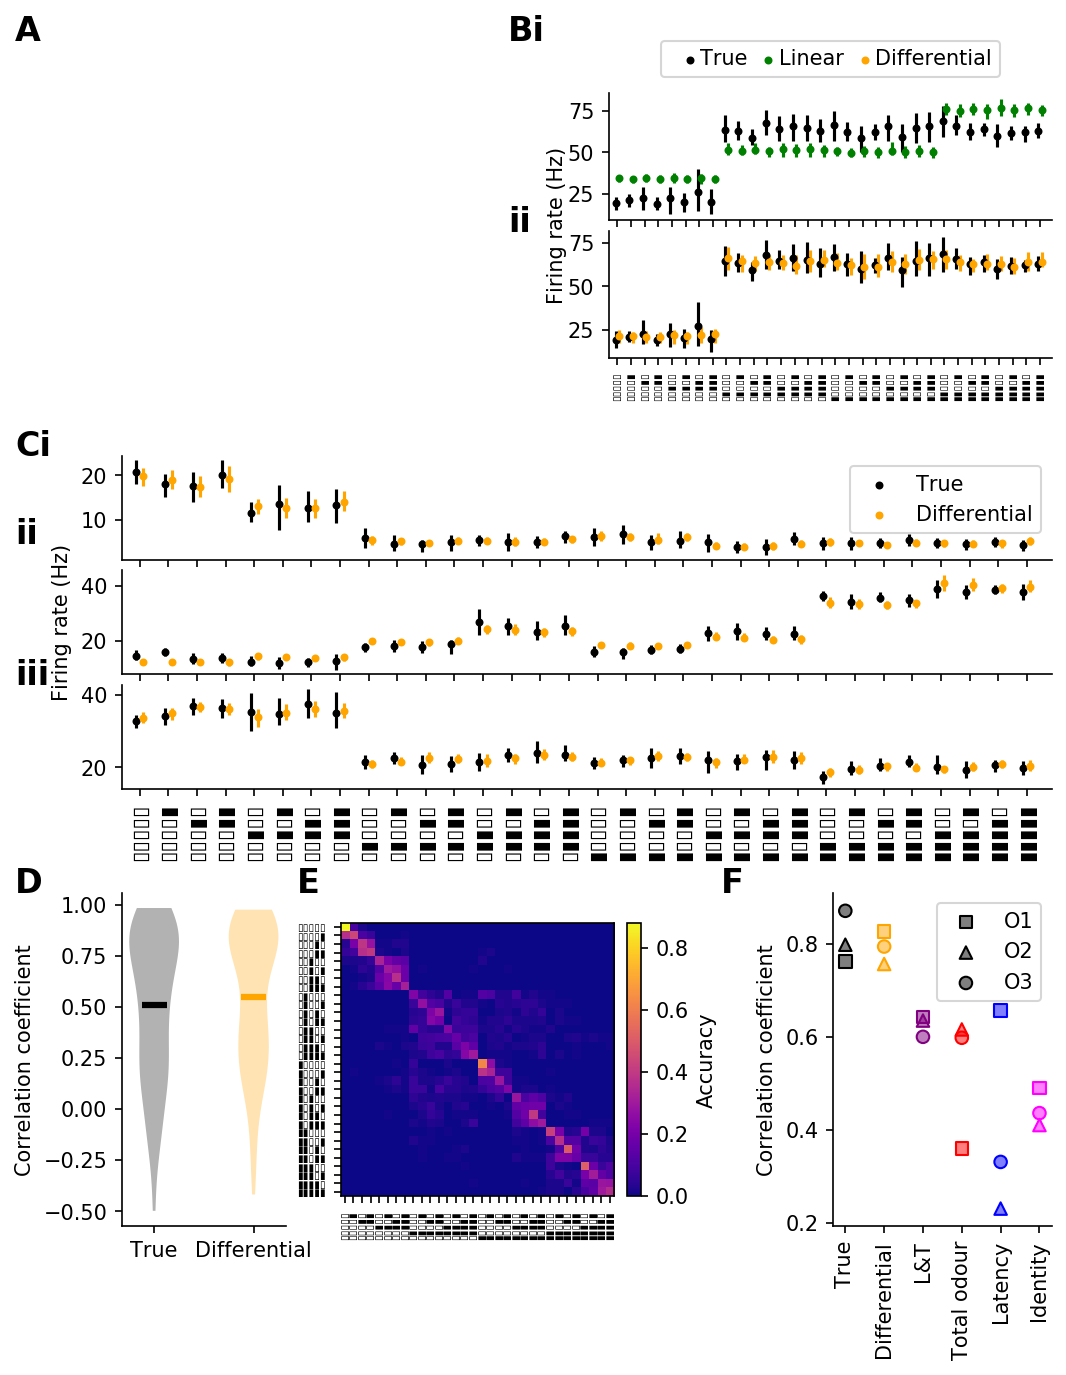

In [15]:
def plot_single_model_fit(ax, model, show_x_labels=False, model_index=[0, 1], ):         
    ax.errorbar(np.arange(0, 32*isi, isi), model.X_test_avg.mean(axis=0), yerr=(model.X_test_avg.mean(axis=0) - model.X_test_avg.min(axis=0), model.X_test_avg.max(axis=0) - model.X_test_avg.mean(axis=0)),fmt='.', color=colors[model_index[0]],  markersize=0, elinewidth=line_thickness)
    ax.scatter(np.arange(0, 32*isi, isi), model.X_test_avg.mean(axis=0), color=colors[model_index[0]], s=s, zorder=10, marker=marker, label=labels[model_index[0]])
    ax.errorbar(np.arange(0+sep, sep+32*isi, isi), model.pred_test_avg.mean(axis=0), yerr=(model.pred_test_avg.mean(axis=0) - model.pred_test_avg.min(axis=0), model.pred_test_avg.max(axis=0) - model.pred_test_avg.mean(axis=0)), fmt='.', color=colors[model_index[1]],  markersize=0, elinewidth=line_thickness)
    ax.scatter(np.arange(sep+0, sep+32*isi, isi), model.pred_test_avg.mean(axis=0), color=colors[model_index[1]], s=s, zorder=10, marker=marker, label=labels[model_index[1]])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks(np.arange(0+sep/2, sep/2+32*isi, isi))
    if show_x_labels:
        ax.set_xticklabels(glyphs, rotation=90)
    else:
        ax.set_xticklabels([])
    ax.set_xlim(-1, 32*isi)

def plot_violin_correlations(ax, models):
    corrs = [np.corrcoef(i.pred_train_avg[0], i.X_test_avg[0])[0, 1] for i in models]
    true_corrs = [np.corrcoef(i.X_train_avg[0], i.X_test_avg[0])[0, 1] for i in models]
    vps = ax.violinplot([true_corrs, corrs], showmeans=True)
    for pc, color in zip(vps['bodies'], colors):
            pc.set_facecolor(color)
    for i in ['cmins', 'cmaxes', 'cmeans', 'cbars']:
        vps[i].set_color(colors)
        vps[i].set_linewidth(3)
    vps['cbars'].set_visible(False)
    vps['cmins'].set_visible(False)
    vps['cmaxes'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(labels)
    ax.set_ylabel('Correlation coefficient')
    return corrs, true_corrs

def plot_significance(ax, x_pos, sig_level, y_level, rotation=False):
    if rotation:
        ax.plot([y_level, y_level], [x_pos[0], x_pos[1]], color='k')
        ax.text(y_level*1.01, np.mean(x_pos), sig_level, horizontalalignment='left', verticalalignment='center', rotation=90)
    else:
        ax.plot([x_pos[0], x_pos[1]], [y_level, y_level], color='k')
        ax.text(np.mean(x_pos), y_level, sig_level, horizontalalignment='center', verticalalignment='bottom')


style_params = json.load(open('../Data/style_params.json', 'r'))

isi=2
sep=0.5
s = 8
marker='o'
line_thickness=1.5
order = ['true', 'diff', 'CAO', 'conc', 'onset', 'base']
labels = [style_params['model_labels'][i] for i in order]
labels = labels[:-1] + ['Identity'] + [labels[-1]]
colors = [style_params['model_colors'][i] for i in order] 
colors = colors[:-1] + ['magenta'] + [colors[-1]]
label_axes_fs = style_params['label_axes_font_size']
label_axes_font_weight = style_params['label_axes_font_weight']

fig = plt.figure(figsize=(8, 10), dpi=150)
gs = GridSpec(9, 3, hspace=1)

top_sub_gs = gs[:3, :].subgridspec(1, 2, wspace=0.1)

schem_ax = fig.add_subplot(top_sub_gs[0], frameon=False)
schem_ax.set_xticks([])
schem_ax.set_yticks([])

step_subgs = top_sub_gs[1].subgridspec(5, 1)
step_ax1 = fig.add_subplot(step_subgs[:2])
step_ax2 = fig.add_subplot(step_subgs[2:4])
index = 2
plot_single_model_fit(step_ax1, base_models1[ordered_scores[index]], model_index=[0, -1])
plot_single_model_fit(step_ax2, diff_models1[ordered_scores[index]])
step_ax2.set_xticklabels(glyphs, rotation=90, fontsize=5)
step_ax1.scatter([], [], s=s, color=colors[1], marker=marker, label=labels[1])
step_ax1.legend(ncol=3,  columnspacing=0, handletextpad=-0.5, loc='upper center', bbox_to_anchor=(0.5, 1.5))
step_label_ax = fig.add_subplot(step_subgs[:4], frameon=False)
step_label_ax.set_xticks([])
step_label_ax.set_yticks([])
step_label_ax.set_ylabel('Firing rate (Hz)', labelpad=20)


sub_gs = gs[3:6, :].subgridspec(3, 1, wspace=0.5, hspace=0.1)
ax1 = fig.add_subplot(sub_gs[0])
ax2 = fig.add_subplot(sub_gs[1])
ax3 = fig.add_subplot(sub_gs[2])
corr_violin_ax = fig.add_subplot(gs[6:, 0])
cm_ax = fig.add_subplot(gs[6:, 1])
cm_x_shift = corr_violin_ax.get_position().width*0.4
cm_pos = [cm_ax.get_position().x0-cm_x_shift, cm_ax.get_position().y0, cm_ax.get_position().width, cm_ax.get_position().height]
corr_violin_ax.set_position([corr_violin_ax.get_position().x0, corr_violin_ax.get_position().y0, corr_violin_ax.get_position().width*0.6, corr_violin_ax.get_position().height])
corr_ax = fig.add_subplot(gs[6:, 2])

unit_ax_y_shift = 0.025
ax1.set_position([ax1.get_position().x0, ax1.get_position().y0+unit_ax_y_shift, ax1.get_position().width, ax1.get_position().height])
ax2.set_position([ax2.get_position().x0, ax2.get_position().y0+unit_ax_y_shift, ax2.get_position().width, ax2.get_position().height])
ax3.set_position([ax3.get_position().x0, ax3.get_position().y0+unit_ax_y_shift, ax3.get_position().width, ax3.get_position().height])








plot_single_model_fit(ax1, diff_models1[ordered_scores[4]])
plot_single_model_fit(ax2, diff_models1[ordered_scores[1]])
plot_single_model_fit(ax3, diff_models1[ordered_scores[3]], show_x_labels=True)
ax2.set_ylabel('Firing rate (Hz)')
ax1.legend()
plot_violin_correlations(corr_violin_ax, diff_models1)
im1, vmax1,cbar = plot_best_cm(cm_ax, cms1, cm_true1, show_xticks=True, colorbar=True, fontsize=5)
cm_ax.set_position(cm_pos)
#plot_significance(corr_violin_ax, [1, 2], '****', 1.05)

cm_ax_pos = cm_ax.get_position()
cbar_ax_pos = cbar.ax.get_position()
cbar.ax.set_position([(cm_ax_pos.x0+cm_ax_pos.width)*1.02, cm_ax_pos.y0, cbar_ax_pos.width, cm_ax_pos.height])
plot_correlations(true_corrs, diff_corrs, joined_corrs, conc_corrs, onset_corrs, identiy, colors[:-1], ax=corr_ax)
cbar.ax.set_ylabel('Accuracy')

corr_ax.set_position([corr_ax.get_position().x0+corr_ax.get_position().width*0.2, corr_ax.get_position().y0, corr_ax.get_position().width*0.8, corr_ax.get_position().height])
axes = [schem_ax, step_ax1, step_ax2, ax1, ax2, ax3, corr_violin_ax, cm_ax, corr_ax]
axes_labels = ['A', 'Bi', 'ii', 'Ci', 'ii', 'iii', 'D', 'E', 'F']
dx = [0, -0.05, -0.05, 0, 0, 0, 0, 0, -0.03]
align_x = [[0, 3, 4, 5, 6], [1, 2]]
align_y = [[0, 1], [6, 7, 8]]
label_axes.label_axes(axes, axes_labels, fontsize=label_axes_fs, fontweight=label_axes_font_weight, align_x=align_x, align_y=align_y, align_x_fun=np.min, align_y_fun=np.max, dx=dx)
plt.savefig('230908_Fig4.pdf', bbox_inches='tight')

In [148]:
import scipy
corrs = [np.corrcoef(i.pred_train_avg[0], i.X_test_avg[0])[0, 1] for i in diff_models1]
true_corrs = [np.corrcoef(i.X_train_avg[0], i.X_test_avg[0])[0, 1] for i in diff_models1]
scipy.stats.ttest_ind(corrs, true_corrs)

Ttest_indResult(statistic=0.8779128703060468, pvalue=0.38080781201620384)

In [111]:
import scipy
scipy.stats.ttest_ind(corrs, true_corrs)

Ttest_indResult(statistic=6.372297124331723, pvalue=8.513859082089615e-10)

Text(0.5, 1.0, '0.08, 0.20')

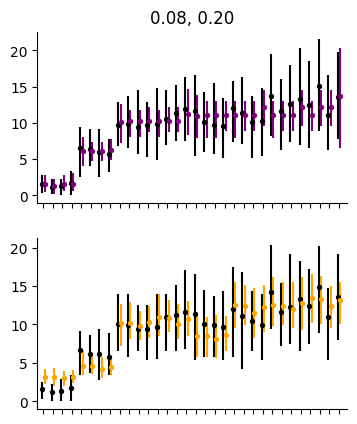

In [144]:
fig, axs = plt.subplots(2, 1, figsize=(4, 5), dpi=100)
index = 48
plot_single_model_fit(axs[0], cao_models1[index], model_index=[0, 2])
plot_single_model_fit(axs[1], diff_models1[index])
axs[0].set_title(f'{smapes_cao1[index]:0.2f}, {smapes_diff1[index]:0.2f}')

In [140]:
smapes_diff = np.array(smapes_cao1) - np.array(smapes_diff1)
smapes_index = np.argsort(smapes_diff)
print(smapes_index)

[ 99  48 126  76 116  40 118  56 114  55 128 104 107   1 115 117  75  83
  80   5  59  79  29  69 112  54 119 106  66  82 127 125  86 111 103  62
  65 102  28 101  70 105  53 109  64 129 108  61  45  93  84   6  14   2
   0  30  71  15  68  20   4 124  22 110  58   8  63  32   9  74  13   7
  11  35  10  97  52  34  88  33  16  89  17  60  38   3  94  25  36  77
  67  57 120  90  87  78  39 113  73  42  72  26  46  19  95  12 100  85
  96  92  47  21  23  27  51  49  37  24  98  41  18 122  81  91  31 121
 123  44  43  50]


26 36


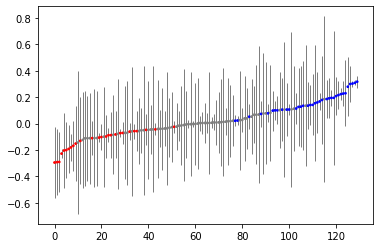

In [19]:
fig, ax = plt.subplots(1, 1)
conc_vs_onset_args = plot_difference_distributions(ax, cao_models1, diff_models1)

0.3390625


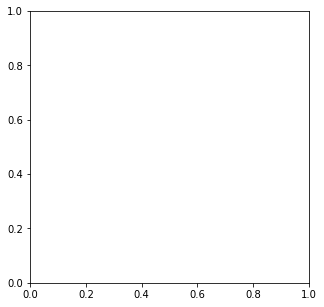

In [93]:
cms = cms1
best_idx = np.argmax([np.corrcoef(i.flatten(), cm_true1.flatten())[0, 1] for i in cms])
print(np.diag(cms[best_idx]).mean())


{'bodies': [<matplotlib.collections.PolyCollection at 0x7fcabfd86e10>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fcabfd86dd8>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fcabfd86fd0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fcabfd35550>}

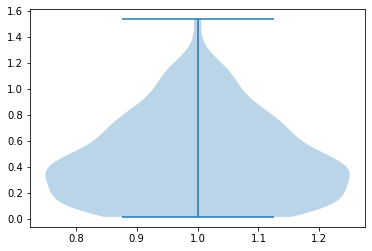

In [23]:
plt.violinplot([i.fit_score for i in cao_models1])

In [27]:
cao_fit_scores = np.array([i.fit_score for i in cao_models1])
print(len(np.where(cao_fit_scores < 0.5)[0]))
diff_fit_scores = np.array([i.fit_score for i in diff_models1])
print(len(np.where(diff_fit_scores < 0.5)[0]))

84
77


In [13]:
[i.fit() for i in cao_models1]
[i.fit() for i in diff_models1]


101
93


In [24]:
cao_fit_scores = np.array([i.fit_score for i in cao_models1])
print(len(np.where(cao_fit_scores < 0.5)[0]))
diff_fit_scores = np.array([i.fit_score for i in diff_models1])
print(len(np.where(diff_fit_scores < 0.5)[0]))
print(np.median(cao_fit_scores), np.median(diff_fit_scores))

101
93
0.31589848784081 0.253970806873525


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f7d597816a0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f7d597815f8>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f7d59781ba8>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f7d59781748>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7f7d597870b8>}

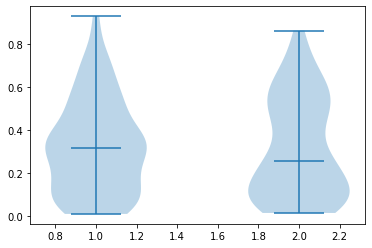

In [21]:
plt.violinplot([cao_fit_scores, diff_fit_scores], showmedians=True)

Ttest_indResult(statistic=0.5601999035031879, pvalue=0.5758291842188104)
Ttest_indResult(statistic=0.43983429385765627, pvalue=0.6604253405059219)
Ttest_indResult(statistic=-1.1318807765812189, pvalue=0.25873547684925613)


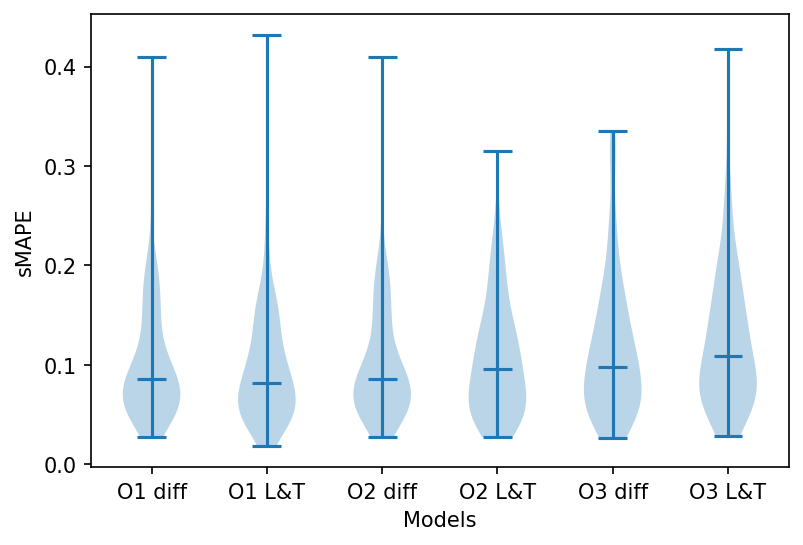

In [110]:
import scipy
y_test = diff_models1[0].true_resp
y_pred = diff_models1[0].pred_resp
smape = lambda y_test, y_pred: 1/16 * (np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))).sum()
smapes_diff1 = [smape(i.true_resp, i.pred_resp) for i in diff_models1]
smapes_diff2 = [smape(i.true_resp, i.pred_resp) for i in diff_models2]
smapes_diff3 = [smape(i.true_resp, i.pred_resp) for i in diff_models3]
smapes_cao1 = [smape(i.true_resp, i.pred_resp) for i in cao_models1]
smapes_cao2 = [smape(i.true_resp, i.pred_resp) for i in cao_models2]
smapes_cao3 = [smape(i.true_resp, i.pred_resp) for i in cao_models3]
plt.figure(dpi=150)
plt.violinplot([smapes_diff1, smapes_cao1, smapes_diff1, smapes_cao2, smapes_diff3, smapes_cao3], showmedians=True)
plt.xticks(range(1, 7), labels=['O1 diff', 'O1 L&T', 'O2 diff', 'O2 L&T', 'O3 diff', 'O3 L&T'])
plt.ylabel('sMAPE')
plt.xlabel('Models')
print(scipy.stats.ttest_ind(smapes_diff1, smapes_cao1))
print(scipy.stats.ttest_ind(smapes_diff2, smapes_cao2))
print(scipy.stats.ttest_ind(smapes_diff3, smapes_cao3))

In [35]:
smapes_base1 = [smape(i.true_resp, i.pred_resp) for i in base_models1]
smapes_base2 = [smape(i.true_resp, i.pred_resp) for i in base_models2]
smapes_base3 = [smape(i.true_resp, i.pred_resp) for i in base_models3]

In [38]:
cut_off = 0.1
print(len(np.where(np.array(smapes_cao1) < cut_off)[0])/130)
print(len(np.where(np.array(smapes_diff1) < cut_off)[0])/130)
print(len(np.where(np.array(smapes_cao2) < cut_off)[0])/130)
print(len(np.where(np.array(smapes_diff2) < cut_off)[0])/130)
print(len(np.where(np.array(smapes_cao3) < cut_off)[0])/130)
print(len(np.where(np.array(smapes_diff3) < cut_off)[0])/130)
print('\n')
print(len(np.where(np.array(smapes_base1) < cut_off)[0])/130)
print(len(np.where(np.array(smapes_base2) < cut_off)[0])/130)
print(len(np.where(np.array(smapes_base3) < cut_off)[0])/130)

0.6076923076923076
0.6384615384615384
0.5307692307692308
0.5461538461538461
0.46923076923076923
0.5076923076923077


0.36923076923076925
0.38461538461538464
0.4


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

50


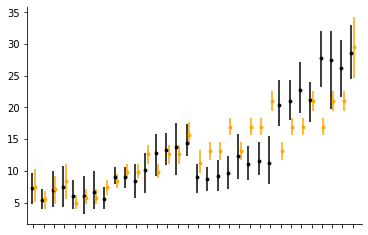

In [17]:
fig, ax = plt.subplots(1, 1)
print(cao_vs_diff_args[-1])
plot_single_model_fit(ax, cao_models1[50])
plot_single_model_fit(ax, )

In [199]:
print(np.mean(conc_corrs), np.mean(onset_corrs), np.mean(joined_corrs), np.mean(identiy))

0.5241406045793415 0.40583289204137746 0.6253251645074839 0.4452102595354008


In [13]:
ordered_scores = [i.test_scores.mean() for i in diff_models1]
ordered_scores = np.argsort(ordered_scores)
corrs = [np.corrcoef(i.true_resp, i.pred_resp)[0, 1] for i in diff_models1]
true_cell_corrs = [np.corrcoef(i.X_train_avg[0], i.X_test_avg[0])[0, 1] for i in diff_models1]
ordered_corrs = np.argsort(corrs)

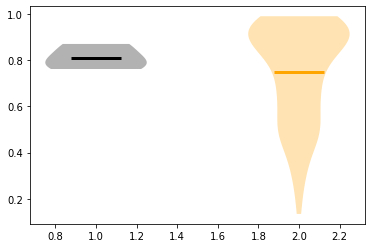

In [12]:
vps = plt.violinplot([true_corrs, corrs], showmeans=True)
colors = [style_params['model_colors']['true'], style_params['model_colors']['diff']]
for pc, color in zip(vps['bodies'], colors):
        pc.set_facecolor(color)
for i in ['cmins', 'cmaxes', 'cmeans', 'cbars']:
    vps[i].set_color(colors)
    vps[i].set_linewidth(3)
vps['cbars'].set_visible(False)
vps['cmins'].set_visible(False)
vps['cmaxes'].set_visible(False)

In [98]:
(model1.X_test_avg[0], model1.X_train_avg[1])

[ 6.28571429  4.25        7.42857286  8.25000125  4.85714429  6.5
  8.28571429  6.          8.5         8.75        8.28571429  9.14285714
 12.5        15.14285714 16.57142857 15.71428571 10.75        9.
  9.25        9.5        11.5        12.25       12.28571429 10.28571429
 20.85714286 22.         23.71428571 23.         26.         25.42857143
 27.25       31.        ] [ 7.          5.14285714  6.50000125  8.00000125  6.00000125  5.42857143
  7.42857143  6.75        8.57142857  8.          6.85714286  9.14285714
 10.85714286 14.25       12.5        13.5         6.75        8.85714286
  8.57142857 11.         12.57142857 11.42857143 10.75       10.
 21.42857143 22.25       23.5        18.75       32.         27.5
 30.57142857 25.71428571]


In [41]:
def split_and_classify(usrt_scattered, trial_indexes, scaled=True, shuffle=False, unit_count=130, classifier=LinearSVC, classifier_params={}):
    unit_indexes = np.random.choice(range(130), replace=False, size=unit_count)
    train, test = ba.split_bs_data(usrt_scattered[unit_indexes])
    train_sum = train.sum(axis=-1)[:, trial_indexes].reshape(unit_count, -1).T
    test_sum = test.sum(axis=-1)[:, trial_indexes].reshape(unit_count, -1).T
    y_train = np.hstack([[i for j in range(60)] for i in trial_indexes])
    y_test = trial_indexes
    
    if scaled:
        scaler = StandardScaler()
        train_sum = scaler.fit_transform(train_sum)
        test_sum = scaler.transform(test_sum)
    svm = classifier(**classifier_params)
    if shuffle:
        np.random.shuffle(y_train)
    svm.fit(train_sum, y_train)
    return svm
def fit_model_and_classify(usrt_scattered):
    model = 

In [44]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
unit_usrt1 = unit_usrt1[good_indexes]
unit_usrt2 = unit_usrt2[good_indexes]
unit_usrt3 = unit_usrt3[good_indexes]

Found odour 1
Found odour 3
Found odour 5


In [45]:
svm = split_and_classify(unit_usrt1, range(32), classifier=RandomForestClassifier)

55


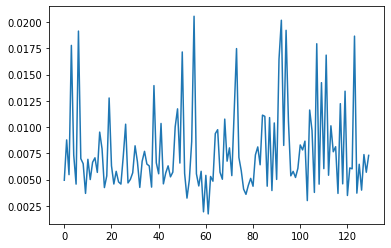

In [49]:
plt.plot(svm.feature_importances_)
print(np.argmax(svm.feature_importances_))

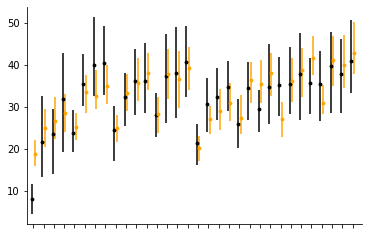

In [51]:
fig, ax1 = plt.subplots(1, 1)
plot_single_model_fit(ax1, diff_models1[55])


In [57]:
model = ebm.ExponentialCustomTrialArray(unit_usrt1, 0, ebm.trial_arrays['diff_array'])

In [59]:
model = diff_models1[0]
print(dir(model))

['X_test_avg', 'X_train_avg', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'fit', 'fit_score', 'fit_scores', 'fit_split', 'fit_withold_trials', 'is_fit', 'loss', 'loss_val', 'minimisation_loss', 'opt_out', 'pred_resp', 'pred_test_avg', 'pred_train_avg', 'test_scores', 'train_scores', 'training_opts', 'trial_array', 'trial_array_full', 'true_resp', 'unit_id', 'unit_sr', 'unit_sr_flat', 'unit_sr_var', 'unit_srt']


In [61]:
print(model.pred_train_avg.shape)

(100, 32)


In [70]:
modelled_spike_counts = np.array([[poisson(i).rvs(3) for i in model.pred_train_avg[0]] for model in diff_models1])
print(modelled_spike_counts.shape)

(130, 32, 3)


In [82]:
classifier = RandomForestClassifier()
X = modelled_spike_counts.reshape(130, -1)
y = [i for i in range(32) for j in range(3)]
y_fake = np.random.randint(0, 32, 96)
classifier.fit(X.T, y_fake)
print(classifier.score(X.T, y_fake))


1.0


[30 14 26  3 24 30 13 27 10 27 25 11 21 27 31 24  9  5 15 18 27  0 28 13
 11 12 24  9  7 19 27  5  9  5 22  6 17 16  5 25 21 19 28 19 31  6 18  9
 13 29 16 11 31 17 21 16  4 25 17  5 25 19  6 22 15 14 23  1 31 16 31 24
 25 27  1  7 19 24 20 23  9  3 14  1  1 26 14 19 23  8  7  8 15  6  7 20]


0.007692307692307693


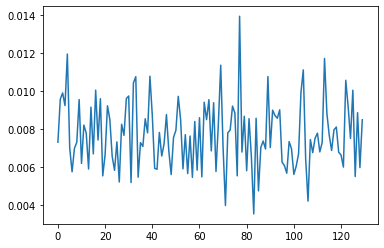

In [79]:
plt.plot(classifier.feature_importances_)
print(np.mean(classifier.feature_importances_))

In [55]:
ebm.trial_arrays['diff_array']

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 1., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 1., 1., 0., 1., 0.],
       [0., 1., 1., 0., 0., 1., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 0., 0., 1.],
       [0., 1., 1., 1., 0., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 1., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1.